# 데이터

In [1]:
# 라이브러리 불러오기
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

import re
from collections import Counter
import sentencepiece as spm
from konlpy.tag import Okt
from konlpy.tag import Mecab
import csv 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
# 한글 폰트에 문제가 생겼을 때

# 한글 폰트 설치
!apt-get update -qq
!apt-get install -qq fonts-nanum

# 설치한 폰트를 matplotlib에서 사용할 수 있도록 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 나눔 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')  # 폰트 설정

## 데이터 업로드

#### 학습 데이터 불러오기

프롬프트로 생성된 '일반 대화' 합성 데이터와 원본 데이터가 합쳐진 파일

In [2]:
train_data_path ="../data/conversations.csv"
train_data = pd.read_csv(train_data_path)
# 원본 데이터 저장
origin_data = train_data

In [ ]:
train_data.sample(10)

In [ ]:
train_data.info()

## Augmentation

## EDA
### 문장 기준 분석

In [3]:
# 클래스 별 대화 확인해보기
class_counts = train_data.groupby('class').size()
class_counts

class
갈취 대화           981
기타 괴롭힘 대화      1094
일반 대화          1000
직장 내 괴롭힘 대화     979
협박 대화           896
dtype: int64

In [4]:
# 대화(X)와 레이블(y)로 나누기
X_train = train_data['conversation']
y_train = train_data['class']

#### 길이 분포 확인

In [5]:
# 길이 분포 확인하기
print('Data Information')
print('-'*50)
print('Conversations :',X_train.shape)
print('Label :',y_train.shape)
print('Label Type:', set(y_train))
print('-'*50)
num_classes = 4
print('The number of classes : {}'.format(num_classes))
print('-'*50)
print('Max Length :{}'.format(max(len(l) for l in X_train)))
print('Average Length :{}'.format(sum(map(len, X_train))/len(X_train)))

Data Information
--------------------------------------------------
Conversations : (4950,)
Label : (4950,)
Label Type: {'일반 대화', '협박 대화', '갈취 대화', '기타 괴롭힘 대화', '직장 내 괴롭힘 대화'}
--------------------------------------------------
The number of classes : 4
--------------------------------------------------
Max Length :874
Average Length :232.0210101010101


#### 클래스 별 분포 확인

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 53440 missing from current font.
  font.set_

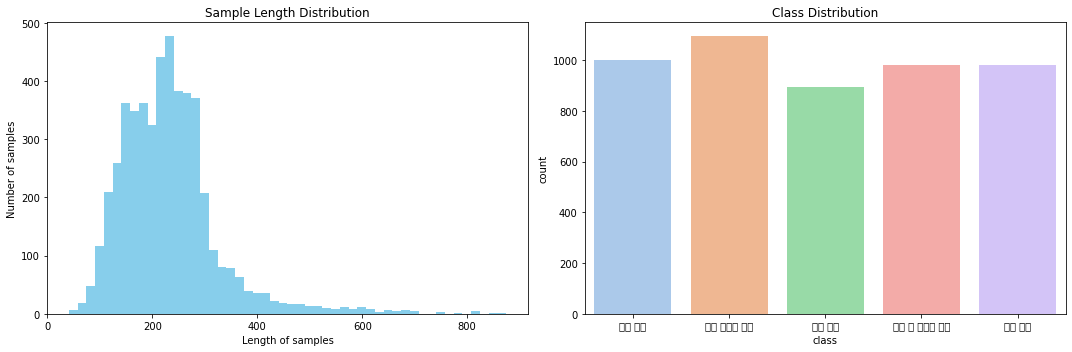

In [6]:
# 두 서브플롯 생성하기
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# 샘플 길이의 히스토그램
axes[0].hist([len(s) for s in X_train], bins=50, color='skyblue')
axes[0].set_xlabel('Length of samples')
axes[0].set_ylabel('Number of samples')
axes[0].set_title('Sample Length Distribution')

# 클래스별 샘플 수 플롯
sns.countplot(x=y_train, ax=axes[1], palette='pastel')
axes[1].set_title('Class Distribution')

# 레이아웃 조정하기
plt.tight_layout()

# 플롯 표시하기
plt.show()

#### 클래스 별 길이 분포 확인

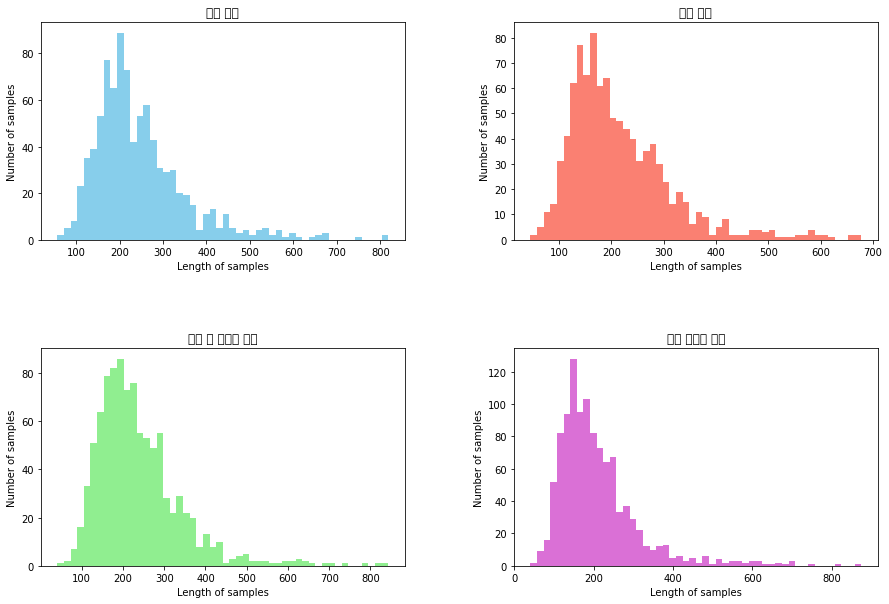

In [7]:
# 서브플롯 생성하기
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# 샘플 길이의 히스토그램 그리기

# 협박 대화
axes[0][0].hist([len(s) for s in train_data['conversation'][train_data['class']=='협박 대화']],
                bins=50, color='skyblue')
axes[0][0].set_xlabel('Length of samples')
axes[0][0].set_ylabel('Number of samples')
axes[0][0].set_title('협박 대화')

# 갈취 대화
axes[0][1].hist([len(s) for s in train_data['conversation'][train_data['class']=='갈취 대화']],
                bins=50, color='salmon')
axes[0][1].set_xlabel('Length of samples')
axes[0][1].set_ylabel('Number of samples')
axes[0][1].set_title('갈취 대화')

# 직장 내 괴롭힘 대화
axes[1][0].hist([len(s) for s in train_data['conversation'][train_data['class']=='직장 내 괴롭힘 대화']],
                bins=50, color='lightgreen')
axes[1][0].set_xlabel('Length of samples')
axes[1][0].set_ylabel('Number of samples')
axes[1][0].set_title('직장 내 괴롭힘 대화')

# 기타 괴롭힘 대화
axes[1][1].hist([len(s) for s in train_data['conversation'][train_data['class']=='기타 괴롭힘 대화']],
                bins=50, color='orchid')
axes[1][1].set_xlabel('Length of samples')
axes[1][1].set_ylabel('Number of samples')
axes[1][1].set_title('기타 괴롭힘 대화')

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

### 단어 기준 분석
Okt 토크나이저로 형태소 분석

In [8]:
# Okt 토크나이저 활용하여 단어 추출
okt=Okt()

형태소 추출 함수 정의

In [9]:
# 텍스트 전처리 함수 정의하기 (특수문자 제거하기)
# 전처리 없이 토큰화할 경우 상위 토큰들이 대부분 특수문자였음
def preprocess_text(text):
    # 특수문자를 공백으로 바꾸기
    text = re.sub(r"([\n?.!,])", " ", text)
    
    # (ㄱ-ㅎ, ㅏ-ㅣ)를 제외한 모든 문자를 없애기
    text = re.sub("[^ㄱ-ㅣ가-힣]", "", text)
    return text

In [10]:
# 형태소를 추출하는 함수 정의하기
def extract_morphs(conversations):
    all_morphs = []
    for conversation in conversations:
        conversation = preprocess_text(conversation)
        morphs = okt.morphs(conversation)
        all_morphs.extend(morphs)
    morph_counter = Counter(all_morphs)
    return morph_counter

In [11]:
# 명사를 추출하는 함수 정의하기
def extract_nouns(conversations):
    all_nouns = []
    for conversation in conversations:
        conversation = preprocess_text(conversation)
        nouns = okt.nouns(conversation)
        all_nouns.extend(nouns)
    noun_counter = Counter(all_nouns)
    return noun_counter

In [12]:
# 상위 10개의 명사와 형태소를 시각화하는 함수
def plot_top_10(noun_data, morph_data, title_noun, title_morph):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # 상위 10개의 명사
    top_10_nouns = noun_data.head(10)
    axs[0].bar(top_10_nouns['Noun'], top_10_nouns['Frequency'], color='skyblue')
    axs[0].set_title(title_noun)
    axs[0].set_xlabel('Noun')
    axs[0].set_ylabel('Frequency')
    axs[0].tick_params(axis='x', rotation=45)

    # 상위 10개의 형태소
    top_10_morphs = morph_data.head(10)
    axs[1].bar(top_10_morphs['Morph'], top_10_morphs['Frequency'], color='lightgreen')
    axs[1].set_title(title_morph)
    axs[1].set_xlabel('Morph')
    axs[1].set_ylabel('Frequency')
    axs[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

#### 클래스 별 사용 단어 비교

In [13]:
# 대화 데이터를 각 클래스별로 나누기
classes = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']
class_data = {cls: train_data[train_data['class'] == cls] for cls in classes}

In [14]:
# 각 클래스별 명사와 형태소를 추출
class_noun_counters = {cls: extract_nouns(data['conversation']) for cls, data in class_data.items()}
class_morph_counters = {cls: extract_morphs(data['conversation']) for cls, data in class_data.items()}

KeyboardInterrupt: 

In [ ]:
# 각 클래스별 명사와 형태소 통계를 데이터프레임으로 전환하기
class_noun_stats = {cls: pd.DataFrame(counter.items(), columns=['Noun', 'Frequency']).sort_values(by='Frequency', ascending=False) for cls, counter in class_noun_counters.items()}
class_morph_stats = {cls: pd.DataFrame(counter.items(), columns=['Morph', 'Frequency']).sort_values(by='Frequency', ascending=False) for cls, counter in class_morph_counters.items()}

In [ ]:
# 각 클래스별 상위 10개의 명사와 형태소를 2x2 서브플롯 형태로 시각화하기
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
plot_titles = {
    '협박 대화': ['Top 10 Nouns in Threatening Conversation', 'Top 10 Morphs in Threatening Conversation'],
    '갈취 대화': ['Top 10 Nouns in Extortion Conversation', 'Top 10 Morphs in Extortion Conversation'],
    '직장 내 괴롭힘 대화': ['Top 10 Nouns in Workplace Harassment', 'Top 10 Morphs in Workplace Harassment'],
    '기타 괴롭힘 대화': ['Top 10 Nouns in Other Harassment', 'Top 10 Morphs in Other Harassment']
}

for i, (cls, noun_data) in enumerate(class_noun_stats.items()):
    morph_data = class_morph_stats[cls]
    plot_top_10(noun_data, morph_data, plot_titles[cls][0], plot_titles[cls][1])

plt.tight_layout()
plt.show()

#### 화자 별 사용 단어 비교

화자 A, B 두 명이라고 가정. 각각이 사용한 명사, 형태소 비교

In [ ]:
# A와 B의 대화를 담을 리스트 초기화하기
A_conversations = []
B_conversations = []

In [ ]:
# 대화 열을 반복하면서 각 대화를 분할하기
for conversation in train_data['conversation']:
    try:
        lines = conversation.split('\n')
        # 홀수 줄은 A, 짝수 줄은 B에 추가하기
        A_conv = '\n'.join([line for idx, line in enumerate(lines) if idx % 2 == 0])
        B_conv = '\n'.join([line for idx, line in enumerate(lines) if idx % 2 == 1])
        A_conversations.append(A_conv)
        B_conversations.append(B_conv)
    except ValueError:
        # 대화가 정확히 두 부분으로 나뉘지 않는 경우 처리하기
        A_conversations.append(conversation)
        B_conversations.append('')

In [ ]:
# A와 B를 위한 새로운 데이터프레임 생성하기
A_data = pd.DataFrame({'idx': train_data['idx'], 'class': train_data['class'], 'conversation': A_conversations})
B_data = pd.DataFrame({'idx': train_data['idx'], 'class': train_data['class'], 'conversation': B_conversations})

In [ ]:
# A의 head() 출력하기
print("A 데이터셋의 첫 5개 행:")
A_data.head()

In [ ]:
# B의 head() 출력하기
print("B 데이터셋의 첫 5개 행:")
B_data.head()

In [ ]:
# A와 B의 명사 추출하기
A_noun_counters = {cls: extract_nouns(A_data['conversation']) for cls, data in class_data.items()}
B_noun_counters = {cls: extract_nouns(B_data['conversation']) for cls, data in class_data.items()}

In [ ]:
# A와 B의 형태소 추출하기
A_morph_counters = {cls: extract_morphs(A_data['conversation']) for cls, data in class_data.items()}
B_morph_counters = {cls: extract_morphs(B_data['conversation']) for cls, data in class_data.items()}

In [ ]:
# 명사 통계를 데이터프레임으로 전환하기
A_noun_stats = {cls: pd.DataFrame(A_noun_counters.items(), columns=['Noun', 'Frequency']).sort_values(by='Frequency', ascending=False) for cls, counter in class_noun_counters.items()}
B_noun_stats = {cls: pd.DataFrame(B_noun_counters.items(), columns=['Morph', 'Frequency']).sort_values(by='Frequency', ascending=False) for cls, counter in class_morph_counters.items()}

In [ ]:
# 형태소 통계를 데이터프레임으로 전환하기
A_morph_stats = {cls: pd.DataFrame(A_noun_counters.items(), columns=['Morph', 'Frequency']).sort_values(by='Frequency', ascending=False) for cls, counter in class_morph_counters.items()}
B_morph_stats = {cls: pd.DataFrame(B_noun_counters.items(), columns=['Morph', 'Frequency']).sort_values(by='Frequency', ascending=False) for cls, counter in class_morph_counters.items()}

In [ ]:
# A와 B 데이터의 상위 10개 명사 및 형태소 시각화
# A 데이터의 상위 10개의 명사와 형태소를 서브플롯으로 그리기
plot_top_10(A_noun_stats, A_morph_stats, 'Top 10 Nouns in A Data', 'Top 10 Morphs in A Data')
plot_top_10(B_noun_stats, B_morph_stats, 'Top 10 Nouns in B Data', 'Top 10 Morphs in B Data')

#### 분석 결과 바탕으로 불용어 리스트 생성

기존 불용어 리스트

In [ ]:
# 불용어 리스트 불러오기
origin_stopwords_path = "stopwords.txt"
with open(stopwords_path, 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()
stopwords

추가 불용어 리스트

In [ ]:
# 추가 불용어 목록
additional_stopwords = [
    '것', '안', '못', '왜', '이', '저', '그', '사람', '너', '저희', '우리', '나', '너희', '당신',
    '하지만', '그리고', '거나', '그러나', '그러면', '그런데', '그러므로', '그래서', '그럼', '근데', '그래',
    '즉', '따라서', '이와', '여기', '저기', '거기', '이곳', '그곳', '저곳', '거기', '하나', '둘', '셋', '넷',
]
# 추가 불용어를 기본 불용어 사전에 추가하기
stopwords.update(additional_stopwords)

In [ ]:
stopwords_path = "ko_stopwords.txt"
with open(stopwords_path, 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()
stopwords

## 전처리

### 기본 전처리

#### 중복값 여부 찾아보기

In [ ]:
# 중복값 찾기
duplicates = train_data[train_data.duplicated()]
duplicates

중복값 없음

#### 결측치 여부 확인하기

In [ ]:
# 결측치 여부 확인하기
train_data.isnull().sum()

결측치 없음

#### 클래스 컬럼 인코딩하기

In [ ]:
# 'class'를 'type'으로 매핑하는 딕셔너리 생성하기
class_to_type = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

In [ ]:
# 'class' 열을 기반으로 새로운 'type' 열 추가하기
train_data['type'] = train_data['class'].map(class_to_type)

In [ ]:
# type 열 추가했는지 확인하기
train_data.head()

In [ ]:
# 기존 idx, class 컬럼 삭제하기
new_train_data = train_data.drop(['idx', 'class'], axis=1)
# idx, class 컬럼 삭제했는지 확인하기
new_train_data.head()

In [ ]:
# new_train_data를 train_data에 덮어 씌우기
train_data = new_train_data

### 텍스트 전처리

#### 한글 외 문자 삭제
한글, '?', '!', '.', '.', 공백 유지

In [ ]:
# 전처리 함수
def preprocess_sentence(sentence): 
    # \n을 공백으로 바꾸기
    sentence = re.sub("\n", " ", sentence)
    
    # (ㄱ-ㅎ, ㅏ-ㅣ, ".", "?", "!", ",", ' ')를 제외한 모든 문자를 없애기
    sentence = re.sub("[^ㄱ-ㅣ가-힣.?!, ]", "", sentence)
    
    # 단어와 구두점(punctuation) 사이에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    return sentence

In [ ]:
# 전처리 데이터 새로운 column에 저장
train_data['preprocessed'] = train_data['conversation'].apply(preprocess_sentence)
train_data['preprocessed']

In [ ]:
# 기존 'conversation' column 전처리한 데이터로 바꾸기
train_data['conversation'] = train_data['preprocessed']
train_data.drop('preprocessed', axis=1)

#### 불용어 삭제
[불용어 리스트 출처](https://www.ranks.nl/stopwords/korean)

In [ ]:
# 불용어 리스트 불러오기
stopwords_path = "ko_stopwords.txt"
with open(stopwords_path, 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()

#### 토큰화

```!pip install sentencepiece```  
```!pip install konlpy```

In [ ]:
# 단어사전 크기 20000으로 제한
VOCAB_SIZE=20000

토크나이저 선정
1. SentencePiece  
[ref](https://wikidocs.net/86657)

In [ ]:
# sentencePiece의 입력으로 사용하기 위해서 데이터를 txt 파일로 저장
with open('conversations.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(train_data['conversation']))

spm.SentencePieceTrainer.Train(
    '--input=conversations.txt ' + 
    '--model_prefix=dktc ' +
    f'--vocab_size={VOCAB_SIZE} ' +
    '--model_type=bpe ' + 
    '--pad_id=0 --pad_piece=<pad> ' +
    '--unk_id=1 --unk_piece=<unk> ' +
    '--bos_id=2 --bos_piece=<sos> ' +
    '--eos_id=3 --eos_piece=<eos> ' + 
    '--max_sentence_length=9999'
)

In [ ]:
word_index_df = pd.read_csv('dktc.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
word_index_df.columns=['words', 'idx']
word_index_df['idx'] = np.arrange(len(word_index_df))
word_to_index = word_index_df.to_dict()

In [ ]:
word_to_index

2. konlpy  
1) Okt  
2) Mecab

In [ ]:
# Okt로 토큰화
tokenizer=Okt()
#tokenizer=Mecab()

def tokenize(conversation, tokenizer):
    return [token for token in tokenizer.morphs(conversation) if token not in stopwords]

# 각 conversation을 토큰화하여 새로운 열 'tokenized'에 저장
train_data['tokenized'] = train_data['conversation'].apply(lambda x: tokenize(x, tokenizer))

#### 시작 토큰, 종료 토큰 추가

In [ ]:
special_tokens = ['<pad>', '<unk>', '<sos>', '<eos>']

# 시작 토큰과 종료 토큰을 추가하는 함수 정의
def add_special_tokens(tokens):
    return [special_tokens[2]] + tokens + [special_tokens[3]]

# 'tokenized' 열에 함수 적용하여 시작 토큰과 종료 토큰 추가
train_data['tokenized'] = train_data['tokenized'].apply(add_special_tokens)

In [ ]:
# 토큰화된 단어 확인
train_data['tokenized']

#### 단어사전 생성

In [ ]:
# 'tokenized' 열의 모든 토큰을 모아 등장 빈도 계산
all_tokens = [token for tokens in train_data['tokenized'] for token in tokens]
counter = Counter(all_tokens)
# 가장 많이 등장하는 단어 vocab_size 개수만큼 남기기
counter = counter.most_common(VOCAB_SIZE)

In [ ]:
# vocabulary 파일로 저장
word_to_index_path = './vocab.txt'

def save_word_index(counter):
    with open(word_to_index_path, 'w') as f:
        for idx, (word, _) in enumerate(counter):
            line = f"{word}: {idx}\n"
            f.write(line)
            
#save_word_index(counter)

In [ ]:
word_to_index = {token: idx for idx, token in enumerate(special_tokens[:2])}
word_to_index.update({token: idx + len(special_tokens[:2]) for idx, (token, _) in enumerate(counter)})

In [ ]:
word_to_index

#### 정수인코딩

In [ ]:
# 'tokenized' 열의 데이터를 정수 인코딩
def encode_tokens(tokens, word_to_index):
    unk_index = word_to_index['<unk>']
    return [word_to_index.get(token, unk_index) for token in tokens]

train_data['encoded'] = train_data['tokenized'].apply(lambda x: encode_tokens(x, word_to_index))

In [ ]:
train_data.sample(3)

## 전처리 후 분석

#### 토큰화된 데이터 길이 확인

In [ ]:
# 'encoded' 열의 각 리스트의 길이 계산
lengths = train_data['encoded'].apply(len)

print(f"최대 길이: {lengths.max()}")
print(f"최소 길이: {lengths.min()}")
print(f"평균 길이: {lengths.mean()}")
print(f"표준편차: {lengths.std()}")

# 길이 분포 시각화
plt.hist(lengths, bins=50, color='skyblue')
plt.show()

#### 패딩 적용

In [ ]:
# 대화 최대 길이 150으로 설정
MAX_LENGTH = 150

In [ ]:
train_data['encoded'] = pad_sequences(train_data['encoded'], maxlen=MAX_LENGTH, padding='post', truncating='post')

## 데이터 분할

In [ ]:
X = train_data['encoded']
y = train_data['type']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, shuffle=True, random_state=42)

print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :', len(y_train))
print('검증 데이터의 개수 :', len(X_val))
print('검증 레이블의 개수 :', len(y_val))
print('테스트 데이터의 개수 :', len(X_test))
print('테스트 레이블의 개수 :', len(y_test))

# 모델링

```!pip install wandb==0.16.0```

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login(key = '809618c39f10bc0019fd6fd710cb28c698c30197')

In [ ]:
sweep_config = {
    "name": "sweep_test_nlp",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            }
                    
        }
    }

In [ ]:
from sklearn.metrics import f1_score

def train():
    default_config = {
        "vocab" : 20000,
        "embeddings" : 64,
        "units_1" : 256,
        "units_2" : 256,
        "units_3" : 1024,
        "class_num" : 5,
        "learning_rate" : 0.005,
        "optimizer" : "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 5,
        "batch_size" : 32
    }

    wandb.init(config = default_config)
    config = wandb.config

    # Model

    model=keras.models.Sequential()
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    model.add(keras.layers.GRU(units = config.units_1, return_sequences = True))
    model.add(keras.layers.GRU(units = config.units_2))
    model.add(keras.layers.Dense(config.units_3, activation='relu'))
    model.add(keras.layers.Dense(config.class_num, activation='softmax'))

    # 머신 러닝 학습때 여러가지 optimzier를 사용할 경우나 learning rate를 조절할 경우에는 아래와 같은 형태의 코드를 응용합니다.

    if config.optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate = config.learning_rate)
    
    model.compile(optimizer = optimizer,
                  loss = config.loss,
                  metrics = config.metrics)

    # WandbCallback 함수는 후술합니다.
    
    model.fit(X_train, y_train,
              epochs = config.epoch,
              batch_size = config.batch_size,
              validation_data = (X_val, y_val),
              callbacks = [WandbCallback()])
    
    test_loss, test_accuracy, test_fs = model.evaluate(X_test, y_test, verbose=2)

    y_pred = model.predict(X_test)
    y_pred_classes = tf.argmax(y_pred, axis=1)
    test_f1 = f1_score(y_test, y_pred_classes, average='weighted')
    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test F1 Score": round(test_f1 * 100, 2)})

In [ ]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = '4-rldur0',
                       project = 'test')

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=10)